In [1]:
import os
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch 
from torch import nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from PIL import Image
import imageio
import time
import pandas as pd
from torch.utils.data import Dataset
import cv2 as cv
from torch.nn import functional as F
from sklearn.model_selection import KFold
import json
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from  sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import random
import torchcam
from torchcam.utils import overlay_mask
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from sklearn.metrics import cohen_kappa_score
from torch.utils.data import WeightedRandomSampler
from torcheval.metrics.functional import r2_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def setup_seed(seed):
#  下面两个常规设置了，用来np和random的话要设置 
    np.random.seed(seed) 
    random.seed(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)  # 禁止hash随机化
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # 在cuda 10.2及以上的版本中，需要设置以下环境变量来保证cuda的结果可复现
    
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 多GPU训练需要设置这个
    torch.manual_seed(seed)
    
    torch.use_deterministic_algorithms(True) # 一些操作使用了原子操作，不是确定性算法，不能保证可复现，设置这个禁用原子操作，保证使用确定性算法
    torch.backends.cudnn.deterministic = True  # 确保每次返回的卷积算法是确定的
    torch.backends.cudnn.enabled = False  # 禁用cudnn使用非确定性算法
    torch.backends.cudnn.benchmark = False  # 与上面一条代码配套使用，True的话会自动寻找最适合当前配置的高效算法，来达到优化运行效率的问题。False保证实验结果可复现。
setup_seed(0)

In [3]:
transform = transforms.Compose([
    #transforms.RandomRotation(60),#随机旋转
    transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转
    transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
    transforms.ToTensor(),
    #transforms.Resize([512,512]),
    #transforms.Normalize([0.5017,0.5021,0.5017],[0.1294,0.1276,0.1195])
    transforms.Normalize([0.5,0.5,0.5],[0.188,0.188,0.188])
])
val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [4]:
class MyDatasetaPb(Dataset):
    def __init__(self,annotations_file,img_dir,a,b,transform=transform):
        self.img_labels = np.array(pd.read_csv(annotations_file,header = None))
        self.img_dir = img_dir
        self.inputlen = a
        self.outputlen = b
        self.transform = transform
    def __getitem__(self, idx):
        img_path = []
        image = []
        for i in range(self.inputlen):
            img_path.append(os.path.join(self.img_dir,str(self.img_labels[idx,i])))
            image.append(self.transform(Image.open(img_path[i])))
        num = self.img_labels[idx,self.inputlen:2*self.inputlen]
        label = self.img_labels[idx,-1]
        #label = self.img_labels[idx,2*self.inputlen:]
        image = torch.stack(image,dim=0)
        num = np.asarray(num,'float32')
        label = np.asarray(label,'float32')
        #if label <= -0.5:
            #label = 1
        #else:
            #label = 0
        return image,num,label
    def __len__(self):
        return len(self.img_labels)

In [5]:
myDataset2P2 = MyDatasetaPb(annotations_file='xulieP/P1/1P1.csv',img_dir='autodl-tmp/all',a=1,b=1,transform = transform)

In [172]:
myDataset2P3 = MyDatasetaPb(annotations_file='xulieP/2P3man.csv',img_dir='autodl-tmp/all',a=2,b=3,transform = transform)

In [5]:
myDataset2P2m = MyDatasetaPb(annotations_file='xulieP/2p2m.csv',img_dir='autodl-tmp/all',a=2,b=2,transform = transform)

In [6]:
myDataset2P2nom = MyDatasetaPb(annotations_file='xulieP/2p2nom.csv',img_dir='autodl-tmp/all',a=2,b=2,transform = transform)

In [5]:
#新
class ResNet34Encoder(nn.Module):
    def __init__(self, pooling='avg'):
        super(ResNet34Encoder, self).__init__()
        resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        #resnet34 = models.resnet34(weights = None)
        self.features = nn.Sequential(*list(resnet34.children())[:-2])  # [batch_size, 512, 16, 16]
        if pooling == 'avg':
            self.pooling = nn.AdaptiveAvgPool2d((1, 1))  # [batch_size, 512, 1, 1]
        elif pooling == 'max':
            self.pooling = nn.AdaptiveMaxPool2d((1, 1))  # [batch_size, 512, 1, 1]
        else:
            raise ValueError("pooling must be either 'avg' or 'max'")
    
    def forward(self, x):
        x = self.features(x)  # [batch_size, 512, 16, 16]
        x = self.pooling(x)  # [batch_size, 512, 1, 1]
        x = x.view(x.size(0), -1)  # [batch_size, 512]
        return x

class ImageSequenceModel(nn.Module):
    def __init__(self, cnn_encoder, seq_len, hidden_size, output_size):
        super(ImageSequenceModel, self).__init__()
        self.cnn_encoder = cnn_encoder
        self.seq_len = seq_len
        self.rnn = nn.LSTM(input_size=512+1, hidden_size=hidden_size, batch_first=True)  # [batch_size, seq_len, 513] -> [batch_size, seq_len, hidden_size]
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(hidden_size, output_size)  # [batch_size, hidden_size] -> [batch_size, output_size]
        

    def forward(self, image_sequence, feature_sequence):
        batch_size, _, _, _, _ = image_sequence.size()  # [batch_size, seq_len, 3, 512, 512]
        cnn_features = []
        for t in range(self.seq_len):
            x = image_sequence[:, t, :, :, :]  # [batch_size, 3, 512, 512]
            cnn_out = self.cnn_encoder(x)  # [batch_size, 512]
            cnn_features.append(cnn_out)
        
        cnn_features = torch.stack(cnn_features, dim=1)  # [batch_size, seq_len, 512]
        rnn_input = torch.cat([cnn_features, feature_sequence], dim=-1)  # [batch_size, seq_len, 513]
        rnn_out, (h_n, c_n) = self.rnn(rnn_input)  # rnn_out: [batch_size, seq_len, hidden_size], h_n: [batch_size, 1, hidden_size]
        #rnn_out, (h_n, c_n) = self.rnn(cnn_features)
        h_n = self.dropout(h_n)
        output = self.linear(h_n.squeeze(0))  # [batch_size, hidden_size] -> [batch_size, output_size]
        return output

# 设置超参数
seq_len = 2
hidden_size = 256
output_size = 2


# 实例化模型
pooling_type = 'avg'  # or 'max'
resnet_encoder = ResNet34Encoder(pooling=pooling_type)
model = ImageSequenceModel(resnet_encoder, seq_len, hidden_size, output_size)


In [51]:
len(myDataset2P2m)

485

In [53]:
train_dataset,val_dataset = torch.utils.data.random_split(myDataset2P2m,[1,484])
val_dataset.dataset.transform = val_transform#将验证集数据增强改为正常的尺寸归一化
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
BATCH_SIZE = 16
BATCH_SIZE2 = 1
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE2,shuffle=True)

using cuda:0 device.


In [9]:
class Mypath(Dataset):

    def __init__(self,annotations_file,img_dir,a,transform=None,target_transform=None):
        self.img_labels = np.array(pd.read_csv(annotations_file,header = None))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.a = a
    def __getitem__(self, idx):
        label1 = self.img_labels[idx,self.a-1]
        label2 = self.img_labels[idx,2*self.a-1]
        return label1,label2
    def __len__(self):
        return len(self.img_labels)

In [5]:
mypath1p1 = Mypath(annotations_file='xulieP/P1/1P1.csv',img_dir='autodl-tmp/all',a=1)
mypath1p2 = Mypath(annotations_file='xulieP/P2/1P2.csv',img_dir='autodl-tmp/all',a=1)
mypath1p3 = Mypath(annotations_file='xulieP/P3/1P3.csv',img_dir='autodl-tmp/all',a=1)
mypath1p4 = Mypath(annotations_file='xulieP/P4/1P4.csv',img_dir='autodl-tmp/all',a=1)
mypath1p5 = Mypath(annotations_file='xulieP/P5/1P5.csv',img_dir='autodl-tmp/all',a=1)
mypath2p1 = Mypath(annotations_file='xulieP/P1/2P1.csv',img_dir='autodl-tmp/all',a=2)
mypath2p2 = Mypath(annotations_file='xulieP/P2/2P2.csv',img_dir='autodl-tmp/all',a=2)
mypath2p3 = Mypath(annotations_file='xulieP/P3/2P3.csv',img_dir='autodl-tmp/all',a=2)
mypath2p4 = Mypath(annotations_file='xulieP/P4/2P4.csv',img_dir='autodl-tmp/all',a=2)
mypath3p1 = Mypath(annotations_file='xulieP/P1/3P1.csv',img_dir='autodl-tmp/all',a=3)
mypath3p2 = Mypath(annotations_file='xulieP/P2/3P2.csv',img_dir='autodl-tmp/all',a=3)
mypath3p3 = Mypath(annotations_file='xulieP/P3/3P3.csv',img_dir='autodl-tmp/all',a=3)
mypath4p1 = Mypath(annotations_file='xulieP/P1/4P1.csv',img_dir='autodl-tmp/all',a=4)
mypath4p2 = Mypath(annotations_file='xulieP/P2/4P2.csv',img_dir='autodl-tmp/all',a=4)
mypath5p1 = Mypath(annotations_file='xulieP/P1/5P1.csv',img_dir='autodl-tmp/all',a=5)

In [6]:
len(mypath1p2)

6631

In [7]:
train_path1p1,val_path1p1 = torch.utils.data.random_split(mypath1p1,[7748,1549])
train_path1p2,val_path1p2 = torch.utils.data.random_split(mypath1p2,[5526,1105])
train_path1p3,val_path1p3 = torch.utils.data.random_split(mypath1p3,[3532,706])
train_path1p4,val_path1p4 = torch.utils.data.random_split(mypath1p4,[2146,429])
train_path1p5,val_path1p5 = torch.utils.data.random_split(mypath1p5,[989,198])
train_path2p1,val_path2p1 = torch.utils.data.random_split(mypath2p1,[4788,957])
train_path2p2,val_path2p2 = torch.utils.data.random_split(mypath2p2,[3016,603])
train_path2p3,val_path2p3 = torch.utils.data.random_split(mypath2p3,[1746,350])
train_path2p4,val_path2p4 = torch.utils.data.random_split(mypath2p4,[701,140])
train_path3p1,val_path3p1 = torch.utils.data.random_split(mypath3p1,[2844,569])
train_path3p2,val_path3p2 = torch.utils.data.random_split(mypath3p2,[1661,332])
train_path3p3,val_path3p3 = torch.utils.data.random_split(mypath3p3,[659,132])
train_path4p1,val_path4p1 = torch.utils.data.random_split(mypath4p1,[1571,314])
train_path4p2,val_path4p2 = torch.utils.data.random_split(mypath4p2,[633,126])
train_path5p1,val_path5p1 = torch.utils.data.random_split(mypath5p1,[597,119])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [8]:
df1p1 = pd.DataFrame(train_path1p1[:][1], columns=None)
df1p2 = pd.DataFrame(train_path1p2[:][1], columns=None)
df1p3 = pd.DataFrame(train_path1p3[:][1], columns=None)
df1p4 = pd.DataFrame(train_path1p4[:][1], columns=None)
df1p5 = pd.DataFrame(train_path1p5[:][1], columns=None)
df2p1 = pd.DataFrame(train_path2p1[:][1], columns=None)
df2p2 = pd.DataFrame(train_path2p2[:][1], columns=None)
df2p3 = pd.DataFrame(train_path2p3[:][1], columns=None)
df2p4 = pd.DataFrame(train_path2p4[:][1], columns=None)
df3p1 = pd.DataFrame(train_path3p1[:][1], columns=None)
df3p2 = pd.DataFrame(train_path3p2[:][1], columns=None)
df3p3 = pd.DataFrame(train_path3p3[:][1], columns=None)
df4p1 = pd.DataFrame(train_path4p1[:][1], columns=None)
df4p2 = pd.DataFrame(train_path4p2[:][1], columns=None)
df5p1 = pd.DataFrame(train_path5p1[:][1], columns=None)

In [9]:
writer = pd.ExcelWriter('train1.xlsx')
df1p1.to_excel(writer, sheet_name='1p1', index=False)
df1p2.to_excel(writer, sheet_name='1p2', index=False)
df1p3.to_excel(writer, sheet_name='1p3', index=False)
df1p4.to_excel(writer, sheet_name='1p4', index=False)
df1p5.to_excel(writer, sheet_name='1p5', index=False)
df2p1.to_excel(writer, sheet_name='2p1', index=False)
df2p2.to_excel(writer, sheet_name='2p2', index=False)
df2p3.to_excel(writer, sheet_name='2p3', index=False)
df2p4.to_excel(writer, sheet_name='2p4', index=False)
df3p1.to_excel(writer, sheet_name='3p1', index=False)
df3p2.to_excel(writer, sheet_name='3p2', index=False)
df3p3.to_excel(writer, sheet_name='3p3', index=False)
df4p1.to_excel(writer, sheet_name='4p1', index=False)
df4p2.to_excel(writer, sheet_name='4p2', index=False)
df5p1.to_excel(writer, sheet_name='5p1', index=False)
writer._save()

In [10]:
df1p1 = pd.DataFrame(train_path1p1[:][0], columns=None)
df1p2 = pd.DataFrame(train_path1p2[:][0], columns=None)
df1p3 = pd.DataFrame(train_path1p3[:][0], columns=None)
df1p4 = pd.DataFrame(train_path1p4[:][0], columns=None)
df1p5 = pd.DataFrame(train_path1p5[:][0], columns=None)
df2p1 = pd.DataFrame(train_path2p1[:][0], columns=None)
df2p2 = pd.DataFrame(train_path2p2[:][0], columns=None)
df2p3 = pd.DataFrame(train_path2p3[:][0], columns=None)
df2p4 = pd.DataFrame(train_path2p4[:][0], columns=None)
df3p1 = pd.DataFrame(train_path3p1[:][0], columns=None)
df3p2 = pd.DataFrame(train_path3p2[:][0], columns=None)
df3p3 = pd.DataFrame(train_path3p3[:][0], columns=None)
df4p1 = pd.DataFrame(train_path4p1[:][0], columns=None)
df4p2 = pd.DataFrame(train_path4p2[:][0], columns=None)
df5p1 = pd.DataFrame(train_path5p1[:][0], columns=None)

In [11]:
writer = pd.ExcelWriter('train2.xlsx')
df1p1.to_excel(writer, sheet_name='1p1', index=False)
df1p2.to_excel(writer, sheet_name='1p2', index=False)
df1p3.to_excel(writer, sheet_name='1p3', index=False)
df1p4.to_excel(writer, sheet_name='1p4', index=False)
df1p5.to_excel(writer, sheet_name='1p5', index=False)
df2p1.to_excel(writer, sheet_name='2p1', index=False)
df2p2.to_excel(writer, sheet_name='2p2', index=False)
df2p3.to_excel(writer, sheet_name='2p3', index=False)
df2p4.to_excel(writer, sheet_name='2p4', index=False)
df3p1.to_excel(writer, sheet_name='3p1', index=False)
df3p2.to_excel(writer, sheet_name='3p2', index=False)
df3p3.to_excel(writer, sheet_name='3p3', index=False)
df4p1.to_excel(writer, sheet_name='4p1', index=False)
df4p2.to_excel(writer, sheet_name='4p2', index=False)
df5p1.to_excel(writer, sheet_name='5p1', index=False)
writer._save()

In [12]:
df1p1 = pd.DataFrame(val_path1p1[:][1], columns=None)
df1p2 = pd.DataFrame(val_path1p2[:][1], columns=None)
df1p3 = pd.DataFrame(val_path1p3[:][1], columns=None)
df1p4 = pd.DataFrame(val_path1p4[:][1], columns=None)
df1p5 = pd.DataFrame(val_path1p5[:][1], columns=None)
df2p1 = pd.DataFrame(val_path2p1[:][1], columns=None)
df2p2 = pd.DataFrame(val_path2p2[:][1], columns=None)
df2p3 = pd.DataFrame(val_path2p3[:][1], columns=None)
df2p4 = pd.DataFrame(val_path2p4[:][1], columns=None)
df3p1 = pd.DataFrame(val_path3p1[:][1], columns=None)
df3p2 = pd.DataFrame(val_path3p2[:][1], columns=None)
df3p3 = pd.DataFrame(val_path3p3[:][1], columns=None)
df4p1 = pd.DataFrame(val_path4p1[:][1], columns=None)
df4p2 = pd.DataFrame(val_path4p2[:][1], columns=None)
df5p1 = pd.DataFrame(val_path5p1[:][1], columns=None)

In [13]:
writer = pd.ExcelWriter('val1.xlsx')
df1p1.to_excel(writer, sheet_name='1p1', index=False)
df1p2.to_excel(writer, sheet_name='1p2', index=False)
df1p3.to_excel(writer, sheet_name='1p3', index=False)
df1p4.to_excel(writer, sheet_name='1p4', index=False)
df1p5.to_excel(writer, sheet_name='1p5', index=False)
df2p1.to_excel(writer, sheet_name='2p1', index=False)
df2p2.to_excel(writer, sheet_name='2p2', index=False)
df2p3.to_excel(writer, sheet_name='2p3', index=False)
df2p4.to_excel(writer, sheet_name='2p4', index=False)
df3p1.to_excel(writer, sheet_name='3p1', index=False)
df3p2.to_excel(writer, sheet_name='3p2', index=False)
df3p3.to_excel(writer, sheet_name='3p3', index=False)
df4p1.to_excel(writer, sheet_name='4p1', index=False)
df4p2.to_excel(writer, sheet_name='4p2', index=False)
df5p1.to_excel(writer, sheet_name='5p1', index=False)
writer._save()

In [14]:
df1p1 = pd.DataFrame(val_path1p1[:][0], columns=None)
df1p2 = pd.DataFrame(val_path1p2[:][0], columns=None)
df1p3 = pd.DataFrame(val_path1p3[:][0], columns=None)
df1p4 = pd.DataFrame(val_path1p4[:][0], columns=None)
df1p5 = pd.DataFrame(val_path1p5[:][0], columns=None)
df2p1 = pd.DataFrame(val_path2p1[:][0], columns=None)
df2p2 = pd.DataFrame(val_path2p2[:][0], columns=None)
df2p3 = pd.DataFrame(val_path2p3[:][0], columns=None)
df2p4 = pd.DataFrame(val_path2p4[:][0], columns=None)
df3p1 = pd.DataFrame(val_path3p1[:][0], columns=None)
df3p2 = pd.DataFrame(val_path3p2[:][0], columns=None)
df3p3 = pd.DataFrame(val_path3p3[:][0], columns=None)
df4p1 = pd.DataFrame(val_path4p1[:][0], columns=None)
df4p2 = pd.DataFrame(val_path4p2[:][0], columns=None)
df5p1 = pd.DataFrame(val_path5p1[:][0], columns=None)

In [15]:
writer = pd.ExcelWriter('val2.xlsx')
df1p1.to_excel(writer, sheet_name='1p1', index=False)
df1p2.to_excel(writer, sheet_name='1p2', index=False)
df1p3.to_excel(writer, sheet_name='1p3', index=False)
df1p4.to_excel(writer, sheet_name='1p4', index=False)
df1p5.to_excel(writer, sheet_name='1p5', index=False)
df2p1.to_excel(writer, sheet_name='2p1', index=False)
df2p2.to_excel(writer, sheet_name='2p2', index=False)
df2p3.to_excel(writer, sheet_name='2p3', index=False)
df2p4.to_excel(writer, sheet_name='2p4', index=False)
df3p1.to_excel(writer, sheet_name='3p1', index=False)
df3p2.to_excel(writer, sheet_name='3p2', index=False)
df3p3.to_excel(writer, sheet_name='3p3', index=False)
df4p1.to_excel(writer, sheet_name='4p1', index=False)
df4p2.to_excel(writer, sheet_name='4p2', index=False)
df5p1.to_excel(writer, sheet_name='5p1', index=False)
writer._save()

In [8]:
def train_and_val(epochs, model, train_loader, val_loader, criterion, optimizer):
    torch.cuda.empty_cache()
    train_loss = []
    val_loss = []
    best_loss = 2.1

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        
        model.train()
        running_loss = 0
        #training_acc = 0
        
        with tqdm(total=len(train_loader)) as pbar:
            for image, num, label in train_loader:
                optimizer.zero_grad()
                image = image.to(device)
                num = num.to(device)
                num = num.unsqueeze(-1)
                label = label.to(device)
                # forward
                output = model(image,num)
                output = output.squeeze(-1)
                output = output.to(torch.float32)
                label = label.to(torch.float32)
                loss = criterion(output, label)
                #predict_t = torch.max(output, dim=1)[1]

                # backward
                torch.use_deterministic_algorithms(False)
                loss.backward()
                optimizer.step()  # update weight

                running_loss += loss.item()
                #training_acc += torch.eq(predict_t, label).sum().item()
                pbar.update(1)

        model.eval()
        val_losses = 0
        #validation_acc = 0
        
        
        with torch.no_grad():#减小内存消耗
            with tqdm(total=len(val_loader)) as pb:
                for image, num, label in val_loader:
                    image = image.to(device)
                    num = num.to(device)
                    num = num.unsqueeze(-1)
                    label = label.to(device)
                    output = model(image,num)
                    output = output.squeeze(-1)
                    output = output.to(torch.float32)
                    label = label.to(torch.float32)
                    # loss
                    loss = criterion(output, label)
                    #predict_v = torch.max(output, dim=1)[1]

                    val_losses += loss.item()
                    #validation_acc += torch.eq(predict_v, label).sum().item()
                    pb.update(1)

            # calculatio mean for each batch
            train_loss.append(running_loss / len(train_loader))
            val_loss.append(val_losses / len(val_loader))

            #train_acc.append(training_acc / len(train_dataset))
            #val_acc.append(validation_acc / len(val_dataset))
            
            torch.save(model, "Xu15.pth")
            #if best_acc<(validation_acc / len(val_dataset)):
                #torch.save(model, "best.pth")
            if best_loss>(val_losses / len(val_loader)):
                torch.save(model, "Xu15b.pth")
                best_loss = val_losses / len(val_loader)
            

            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss_mae: {:.6f}..".format(running_loss / len(train_loader)),
                  "Val Loss_mae: {:.6f}..".format(val_losses / len(val_loader)),
                  "Time: {:.2f}s".format((time.time() - since)))
            

    history = {'train_loss': train_loss, 'val_loss': val_loss}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    
    return history

In [9]:
net = model

In [10]:
net

ImageSequenceModel(
  (cnn_encoder): ResNet34Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [8]:
#分类器
def train_and_val(epochs, model, train_loader, val_loader, criterion, optimizer):
    torch.cuda.empty_cache()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_acc = 0.9

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        
        model.train()
        running_loss = 0
        training_acc = 0
        
        with tqdm(total=len(train_loader)) as pbar:
            for image, num, label in train_loader:
                optimizer.zero_grad()
                image = image.to(device)
                num = num.to(device)
                num = num.unsqueeze(-1)
                label = label.to(device)
                # forward
                output = model(image,num)
                output = output.squeeze(-1)
                loss = criterion(output, label)
                predict_t = torch.max(output, dim=1)[1]

                # backward
                loss.backward()
                optimizer.step()  # update weight

                running_loss += loss.item()
                training_acc += torch.eq(predict_t, label).sum().item()
                pbar.update(1)

        model.eval()
        val_losses = 0
        validation_acc = 0
        
        
        with torch.no_grad():#减小内存消耗
            with tqdm(total=len(val_loader)) as pb:
                for image, num, label in val_loader:
                    image = image.to(device)
                    num = num.to(device)
                    num = num.unsqueeze(-1)
                    label = label.to(device)
                    output = model(image,num)
                    output = output.squeeze(-1)
                    # loss
                    loss = criterion(output, label)
                    predict_v = torch.max(output, dim=1)[1]

                    val_losses += loss.item()
                    validation_acc += torch.eq(predict_v, label).sum().item()
                    pb.update(1)

            # calculatio mean for each batch
            train_loss.append(running_loss / len(train_loader))
            val_loss.append(val_losses / len(val_loader))

            train_acc.append(training_acc / len(train_dataset))
            val_acc.append(validation_acc / len(val_dataset))
            if (validation_acc / len(val_dataset)) > best_acc:
                best_acc = validation_acc / len(val_dataset)
                torch.save(model, "Fen11bx.pth")
            torch.save(model, "Fen11x.pth")
            

            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Acc: {:.6f}..".format(training_acc / len(train_dataset)),
                  "Val Acc: {:.6f}..".format(validation_acc / len(val_dataset)),
                  "Train Loss: {:.6f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.6f}..".format(val_losses / len(val_loader)),
                  "Time: {:.2f}s".format((time.time() - since)))
            

    history = {'train_loss': train_loss, 'val_loss': val_loss,'train_acc': train_acc, 'val_acc': val_acc}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    
    return history

In [18]:
#loss_function = nn.CrossEntropyLoss()  # 设置损失函数
loss_function = nn.MSELoss()  # 设置损失函数
optimizer = optim.Adam(net.parameters(),lr=0.00005,weight_decay = 0)  
epoch = 30
history = train_and_val(epoch, net, train_dataloader, val_dataloader, loss_function, optimizer)

100%|██████████| 198/198 [00:03<00:00, 63.51it/s]


Epoch:1/30.. Train Loss_mae: 1.878112.. Val Loss_mae: 2.095253.. Time: 30.57s


100%|██████████| 198/198 [00:03<00:00, 64.50it/s]


Epoch:2/30.. Train Loss_mae: 1.901975.. Val Loss_mae: 2.143632.. Time: 26.38s


100%|██████████| 198/198 [00:03<00:00, 51.58it/s]


Epoch:3/30.. Train Loss_mae: 1.851321.. Val Loss_mae: 2.118382.. Time: 29.03s


100%|██████████| 198/198 [00:03<00:00, 64.89it/s]


Epoch:4/30.. Train Loss_mae: 1.793991.. Val Loss_mae: 2.139264.. Time: 26.68s


100%|██████████| 198/198 [00:03<00:00, 52.64it/s]


Epoch:5/30.. Train Loss_mae: 1.781483.. Val Loss_mae: 2.105425.. Time: 27.98s


100%|██████████| 198/198 [00:03<00:00, 63.44it/s]


Epoch:6/30.. Train Loss_mae: 1.772504.. Val Loss_mae: 2.248088.. Time: 26.63s


100%|██████████| 198/198 [00:03<00:00, 59.40it/s]


Epoch:7/30.. Train Loss_mae: 1.728964.. Val Loss_mae: 2.160857.. Time: 30.85s


100%|██████████| 198/198 [00:03<00:00, 65.26it/s]


Epoch:8/30.. Train Loss_mae: 1.685326.. Val Loss_mae: 2.332493.. Time: 26.12s


100%|██████████| 198/198 [00:03<00:00, 61.09it/s]


Epoch:9/30.. Train Loss_mae: 1.646430.. Val Loss_mae: 2.146794.. Time: 29.43s


100%|██████████| 198/198 [00:02<00:00, 70.17it/s]


Epoch:10/30.. Train Loss_mae: 1.584532.. Val Loss_mae: 2.252834.. Time: 27.45s


100%|██████████| 198/198 [00:02<00:00, 70.27it/s]


Epoch:11/30.. Train Loss_mae: 1.625617.. Val Loss_mae: 2.468149.. Time: 27.66s


100%|██████████| 198/198 [00:03<00:00, 52.11it/s]


Epoch:12/30.. Train Loss_mae: 1.485782.. Val Loss_mae: 2.489221.. Time: 28.31s


100%|██████████| 198/198 [00:03<00:00, 60.83it/s]


Epoch:13/30.. Train Loss_mae: 1.451410.. Val Loss_mae: 2.256809.. Time: 32.02s


100%|██████████| 198/198 [00:02<00:00, 69.41it/s]


Epoch:14/30.. Train Loss_mae: 1.330007.. Val Loss_mae: 2.732377.. Time: 30.75s


100%|██████████| 198/198 [00:03<00:00, 51.28it/s]


Epoch:15/30.. Train Loss_mae: 1.258611.. Val Loss_mae: 2.358800.. Time: 32.04s


100%|██████████| 198/198 [00:02<00:00, 66.03it/s]


Epoch:16/30.. Train Loss_mae: 1.214517.. Val Loss_mae: 2.585820.. Time: 27.76s


100%|██████████| 198/198 [00:03<00:00, 59.44it/s]


Epoch:17/30.. Train Loss_mae: 1.216804.. Val Loss_mae: 2.536783.. Time: 28.37s


100%|██████████| 198/198 [00:03<00:00, 65.85it/s]


Epoch:18/30.. Train Loss_mae: 1.153163.. Val Loss_mae: 2.463638.. Time: 27.57s


100%|██████████| 198/198 [00:03<00:00, 61.94it/s]


Epoch:19/30.. Train Loss_mae: 1.046214.. Val Loss_mae: 2.960587.. Time: 30.48s


100%|██████████| 198/198 [00:02<00:00, 70.49it/s]


Epoch:20/30.. Train Loss_mae: 1.003132.. Val Loss_mae: 3.075655.. Time: 29.14s


100%|██████████| 198/198 [00:03<00:00, 60.97it/s]


Epoch:21/30.. Train Loss_mae: 0.952542.. Val Loss_mae: 2.909347.. Time: 28.47s


100%|██████████| 198/198 [00:02<00:00, 68.47it/s]


Epoch:22/30.. Train Loss_mae: 0.878953.. Val Loss_mae: 2.600121.. Time: 26.14s


100%|██████████| 198/198 [00:03<00:00, 57.28it/s]


Epoch:23/30.. Train Loss_mae: 0.741082.. Val Loss_mae: 2.729219.. Time: 26.20s


100%|██████████| 198/198 [00:03<00:00, 65.28it/s]


Epoch:24/30.. Train Loss_mae: 0.745931.. Val Loss_mae: 2.731463.. Time: 30.04s


100%|██████████| 198/198 [00:02<00:00, 66.86it/s]


Epoch:25/30.. Train Loss_mae: 0.760986.. Val Loss_mae: 2.805169.. Time: 29.76s


100%|██████████| 198/198 [00:03<00:00, 64.47it/s]


Epoch:26/30.. Train Loss_mae: 0.662265.. Val Loss_mae: 2.632015.. Time: 29.24s


100%|██████████| 198/198 [00:02<00:00, 68.38it/s]


Epoch:27/30.. Train Loss_mae: 0.606737.. Val Loss_mae: 2.532431.. Time: 25.07s


100%|██████████| 198/198 [00:02<00:00, 69.46it/s]


Epoch:28/30.. Train Loss_mae: 0.562915.. Val Loss_mae: 2.504747.. Time: 26.07s


100%|██████████| 198/198 [00:03<00:00, 63.87it/s]


Epoch:29/30.. Train Loss_mae: 0.634823.. Val Loss_mae: 2.812721.. Time: 26.78s


100%|██████████| 198/198 [00:03<00:00, 57.53it/s]


Epoch:30/30.. Train Loss_mae: 0.561713.. Val Loss_mae: 2.773370.. Time: 25.70s
Total time: 14.14 m


In [10]:
net = torch.load("Xu22b.pth")

In [21]:
net.linear = nn.Linear(256, 2)

In [22]:
net.to(device)

ImageSequenceModel(
  (cnn_encoder): ResNet34Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [69]:
weight = torch.from_numpy(np.array([0.05,0.95])).cuda().to(torch.float32)
loss_function = nn.CrossEntropyLoss(weight = weight)  # 设置损失函数
optimizer = optim.Adam(net.linear.parameters(),lr=0.0002,weight_decay = 0)  
epoch = 2
history = train_and_val(epoch, net, train_dataloader, val_dataloader, loss_function, optimizer)

100%|██████████| 126/126 [00:06<00:00, 19.61it/s]


Epoch:1/2.. Train Acc: 0.985782.. Val Acc: 0.984127.. Train Loss: 0.181467.. Val Loss: 0.051424.. Time: 57.56s


100%|██████████| 126/126 [00:06<00:00, 19.67it/s]


Epoch:2/2.. Train Acc: 0.985782.. Val Acc: 0.984127.. Train Loss: 0.167340.. Val Loss: 0.056442.. Time: 55.41s
Total time: 1.88 m


In [9]:
net = torch.load("Fen11b.pth")

In [10]:
net.to(device)

ImageSequenceModel(
  (cnn_encoder): ResNet34Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [11]:
loss_function = nn.CrossEntropyLoss()  # 设置损失函数
optimizer = optim.Adam(net.parameters(),lr=0.0001,weight_decay = 0.01)  
epoch = 10
history = train_and_val(epoch, net, train_dataloader, val_dataloader, loss_function, optimizer)

100%|██████████| 1549/1549 [00:25<00:00, 61.10it/s]


Epoch:1/10.. Train Acc: 0.914300.. Val Acc: 0.928986.. Train Loss: 0.215208.. Val Loss: 0.202358.. Time: 232.14s


100%|██████████| 1549/1549 [00:24<00:00, 63.17it/s]


Epoch:2/10.. Train Acc: 0.915591.. Val Acc: 0.924467.. Train Loss: 0.213465.. Val Loss: 0.202061.. Time: 215.35s


100%|██████████| 1549/1549 [00:22<00:00, 70.33it/s]


Epoch:3/10.. Train Acc: 0.916753.. Val Acc: 0.927050.. Train Loss: 0.212021.. Val Loss: 0.203119.. Time: 201.30s


100%|██████████| 1549/1549 [00:22<00:00, 69.42it/s]


Epoch:4/10.. Train Acc: 0.915720.. Val Acc: 0.915429.. Train Loss: 0.205377.. Val Loss: 0.227084.. Time: 201.40s


100%|██████████| 1549/1549 [00:24<00:00, 62.68it/s]


Epoch:5/10.. Train Acc: 0.922303.. Val Acc: 0.914138.. Train Loss: 0.194841.. Val Loss: 0.220385.. Time: 232.59s


100%|██████████| 1549/1549 [00:22<00:00, 67.42it/s]


Epoch:6/10.. Train Acc: 0.937919.. Val Acc: 0.914784.. Train Loss: 0.168069.. Val Loss: 0.239730.. Time: 210.19s


100%|██████████| 1549/1549 [00:23<00:00, 65.33it/s]


Epoch:7/10.. Train Acc: 0.962313.. Val Acc: 0.892834.. Train Loss: 0.114580.. Val Loss: 0.281327.. Time: 235.25s


100%|██████████| 1549/1549 [00:22<00:00, 68.62it/s]


Epoch:8/10.. Train Acc: 0.983609.. Val Acc: 0.883150.. Train Loss: 0.064597.. Val Loss: 0.439749.. Time: 223.81s


100%|██████████| 1549/1549 [00:23<00:00, 66.86it/s]


Epoch:9/10.. Train Acc: 0.992514.. Val Acc: 0.881214.. Train Loss: 0.035757.. Val Loss: 0.438216.. Time: 210.88s


100%|██████████| 1549/1549 [00:22<00:00, 69.16it/s]


Epoch:10/10.. Train Acc: 0.994063.. Val Acc: 0.877986.. Train Loss: 0.026820.. Val Loss: 0.461296.. Time: 212.17s
Total time: 36.25 m


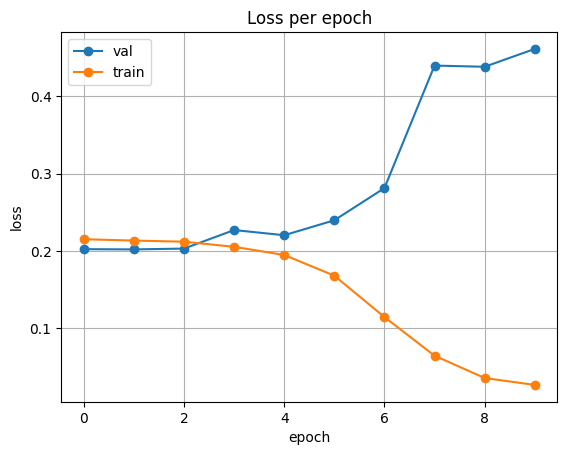

In [13]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(np.arange(0,epoch), history)

In [50]:
net

ImageSequenceModel(
  (cnn_encoder): ResNet34Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [57]:
def bland_altman_plot(pre0, tru0, *args, **kwargs):
    diff = pre0 - tru0
    mean = (pre0+tru0)/2
    mean_diff = diff.mean()
    std_diff = diff.std()

    u = mean_diff+1.96*std_diff
    d = mean_diff-1.96*std_diff

    plt.scatter(mean,diff,s=1)

    plt.axhline(y=mean_diff,color='red',linestyle='--')
    plt.axhline(y=0,color='gray',linestyle='-')
    plt.axhline(y=u,color='red',linestyle='--')
    plt.axhline(y=d,color='red',linestyle='--')

    plt.annotate("+1.96 SD",c='red',xy=(2,u+0.1))
    plt.annotate("Mean",c='red',xy=(2.2,mean_diff+0.1))
    plt.annotate("-1.96 SD",c='red',xy=(2,d+0.1))
    plt.xlabel('Mean of pre and tru')
    plt.ylabel('Difference between pre and tru')
    plt.title('Myopia Bland-Altman MAE=0.27')
    plt.ylim((-1.5, 1.5))
    plt.show()

In [54]:
tru = []
pre = []
model = torch.load("Xu22b.pth")
criterion = nn.L1Loss()
with torch.no_grad():#减小内存消耗
    with tqdm(total=len(val_dataloader)) as pb:
        for image, num, label in val_dataloader:
            image = image.to(device)
            num = num.to(device)
            num = num.unsqueeze(-1)
            label = label.to(device)
            output = model(image,num)
            output = output.squeeze(-1)
            output = output.cpu().numpy()[0]
            label = label.cpu().numpy()[0]
            pre.append(output)
            tru.append(label)

  0%|          | 0/484 [00:13<?, ?it/s]


In [55]:
pre = np.array(pre)
tru = np.array(tru)

In [56]:
mae = np.mean(abs(pre-tru))
mae

0.26905575

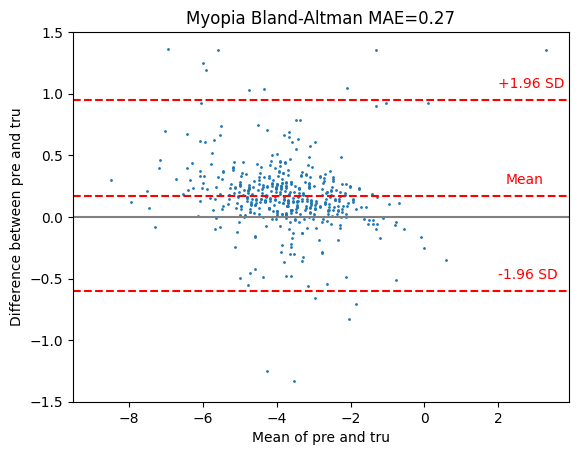

In [58]:
bland_altman_plot(pre, tru)

In [49]:
def bland_altman_plot(pre0, tru0, *args, **kwargs):
    diff = pre0 - tru0
    mean = (pre0+tru0)/2
    mean_diff = diff.mean()
    std_diff = diff.std()

    u = mean_diff+1.96*std_diff
    d = mean_diff-1.96*std_diff

    plt.scatter(mean,diff,s=1)

    plt.axhline(y=mean_diff,color='red',linestyle='--')
    plt.axhline(y=0,color='gray',linestyle='-')
    plt.axhline(y=u,color='red',linestyle='--')
    plt.axhline(y=d,color='red',linestyle='--')

    plt.annotate("+1.96 SD",c='red',xy=(6.6,u+0.1))
    plt.annotate("Mean",c='red',xy=(6.8,mean_diff+0.1))
    plt.annotate("-1.96 SD",c='red',xy=(6.6,d+0.1))
    plt.xlabel('Mean of pre and tru')
    plt.ylabel('Difference between pre and tru')
    plt.title('Non Myopia Bland-Altman MAE=0.17')
    plt.ylim((-1.5, 1.5))
    plt.show()

In [34]:
pre = np.array(pre)
tru = np.array(tru)

In [48]:
mae = np.mean(abs(pre-tru))
mae

0.17367324

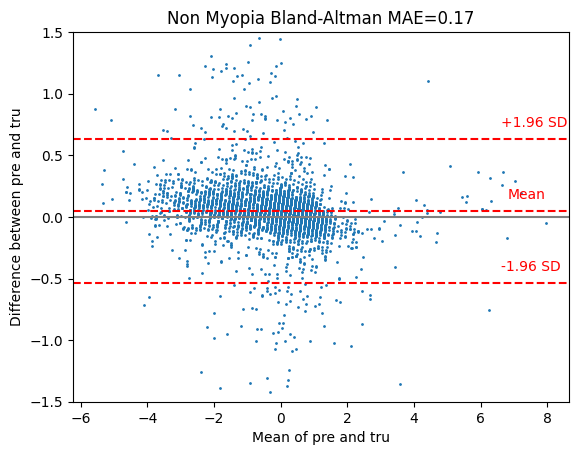

In [50]:
bland_altman_plot(pre, tru)

In [175]:
net = torch.load("Fen23b.pth")

In [182]:
tru = []
pre = []
with torch.no_grad():#减小内存消耗
    with tqdm(total=len(val_dataloader)) as pb:
        for image, num, label in val_dataloader:
            image = image.to(device)
            num = num.to(device)
            num = num.unsqueeze(-1)
            label = label.to(device)
            output = net(image,num)
            output = F.softmax(output, dim=1)
            output = output[:, 1].cpu().numpy()
            label = label.cpu().numpy()
            tru.extend(label)
            pre.extend(output)

  0%|          | 0/1171 [00:31<?, ?it/s]


In [184]:
fpr23m, tpr23m, thresholds23m = roc_curve(tru, pre)

In [178]:
len(pre)

1171

In [183]:
for i in range(1171):
        pre[i] = pre[i]*19/20 + tru[i]/20

In [170]:
fpr23w, tpr23w, thresholds23w = roc_curve(tru, pre)

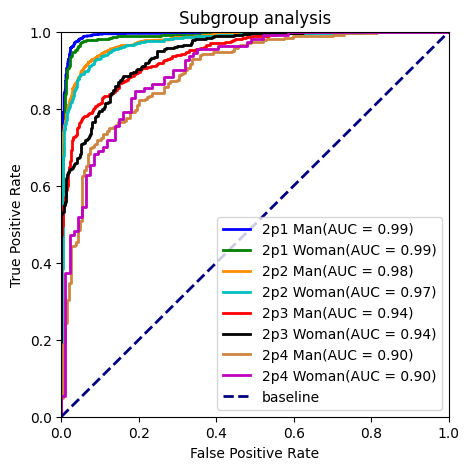

In [186]:
# 计算AUC
roc_auc21m = auc(fpr21m, tpr21m)
roc_auc21w = auc(fpr21w, tpr21w)
roc_auc22m = auc(fpr22m, tpr22m)
roc_auc22w = auc(fpr22w, tpr22w)
roc_auc23m = auc(fpr23m, tpr23m)
roc_auc23w = auc(fpr23w, tpr23w)
roc_auc24m = auc(fpr24m, tpr24m)
roc_auc24w = auc(fpr24w, tpr24w)
# 绘制ROC曲线
plt.figure(figsize=(5,5))
plt.plot(fpr22m, tpr22m, color='b', lw=2, label='2p1 Man(AUC = %0.2f)' % roc_auc22m)
plt.plot(fpr22w, tpr22w, color='g', lw=2, label='2p1 Woman(AUC = %0.2f)' % roc_auc22w)
plt.plot(fpr21m, tpr21m, color='darkorange', lw=2, label='2p2 Man(AUC = %0.2f)' % roc_auc21m)
plt.plot(fpr21w, tpr21w, color='c', lw=2, label='2p2 Woman(AUC = %0.2f)' % roc_auc21w)
plt.plot(fpr23m, tpr23m, color='r', lw=2, label='2p3 Man(AUC = %0.2f)' % roc_auc23m)
plt.plot(fpr23w, tpr23w, color='black', lw=2, label='2p3 Woman(AUC = %0.2f)' % roc_auc23w)
plt.plot(fpr24m, tpr24m, color='peru', lw=2, label='2p4 Man(AUC = %0.2f)' % roc_auc24m)
plt.plot(fpr24w, tpr24w, color='m', lw=2, label='2p4 Woman(AUC = %0.2f)' % roc_auc24w)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Subgroup analysis')
plt.legend(loc="lower right")
plt.show()

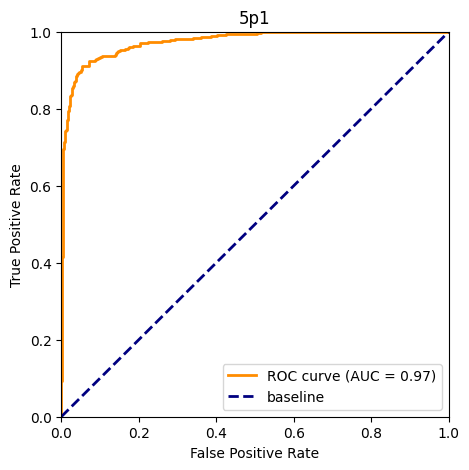

0.9743642913627977

In [16]:
fpr, tpr, thresholds = roc_curve(tru, pre)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, color='darkorange', lw=2, label='G ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5p1')
plt.legend(loc="lower right")
plt.show()
roc_auc

In [12]:
ppre=pre
for i in range(len(pre)):
    if pre[i]<=0.5:
        ppre[i] = 0
    if pre[i]>0.5:
        ppre[i]=1

Accuracy is : 0.9596977329974811
              precision    recall  f1-score   support

     healthy       0.95      0.96      0.95       702
      myopic       0.96      0.96      0.96       886

    accuracy                           0.96      1588
   macro avg       0.96      0.96      0.96      1588
weighted avg       0.96      0.96      0.96      1588



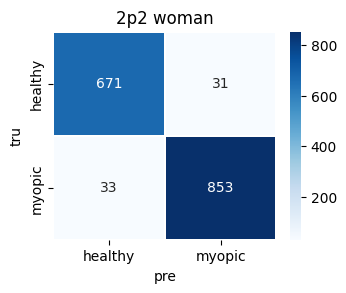

In [13]:
classes = ('healthy', 'myopic')
#classes = ('normal', 'high myopic')
ac = accuracy_score(tru, pre)
cm = confusion_matrix(tru, pre)
cr = classification_report(tru, pre, target_names=classes)
print("Accuracy is :",ac) 
print(cr)
labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(3.6,2.7))
sns.heatmap(cm,cmap='Blues', annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
plt.ylabel('tru')
plt.xlabel('pre')
plt.title('2p2 woman')
plt.show()

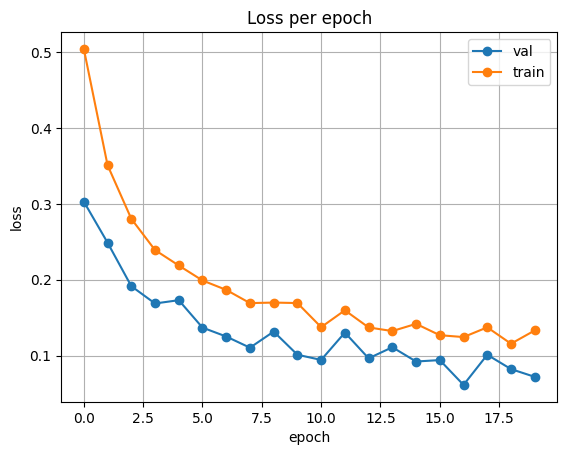

In [31]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(np.arange(0,epoch), history)

In [9]:
tru = []
pre = []
model = torch.load("Xu22b.pth")
criterion = nn.L1Loss()
with torch.no_grad():#减小内存消耗
    with tqdm(total=len(val_dataloader)) as pb:
        for image, num, label in val_dataloader:
            image = image.to(device)
            num = num.to(device)
            num = num.unsqueeze(-1)
            label = label.to(device)
            output = model(image,num)
            output = output.squeeze(-1)
            output = output.cpu().numpy()[0]
            label = label.cpu().numpy()[0]
            pre.append(output)
            tru.append(label)

  0%|          | 0/2029 [00:56<?, ?it/s]


In [9]:
pre

[-0.021966372,
 0.5158747,
 -3.0044637,
 -3.2777178,
 -2.8790965,
 -2.2633762,
 -4.0805044,
 -1.2202436,
 -1.945731,
 -1.542525,
 -0.7683691,
 -1.1026664,
 0.12292195,
 0.110420294,
 0.43948716,
 -2.524652,
 -0.9075736,
 -1.0051423,
 -2.40713,
 -0.3893308,
 -0.21064535,
 -1.6597468,
 0.21943381,
 -0.4353878,
 -3.583353,
 -1.0447282,
 0.6569934,
 0.37140176,
 -0.2240111,
 -0.5891235,
 -0.09011454,
 2.3740857,
 -0.71245325,
 -0.04407402,
 -2.6810412,
 5.919979,
 -1.9211057,
 0.6130435,
 -3.9365172,
 -0.13547435,
 -0.34477997,
 -2.5672314,
 -0.0069035627,
 -5.114486,
 0.1287655,
 -1.398395,
 -0.85261184,
 -1.2759026,
 -0.87837064,
 0.7522359,
 -2.9723825,
 -0.43601212,
 -0.57227844,
 -2.8797665,
 0.6011411,
 -3.1660156,
 0.3398237,
 -3.9363663,
 -1.8570309,
 0.37651348,
 0.2820941,
 -1.0079268,
 -4.5259967,
 -0.9762765,
 -4.323776,
 -0.8890133,
 -1.6134545,
 -1.6974126,
 -2.539559,
 -0.5525459,
 -1.103852,
 -0.36365834,
 -1.0872961,
 -4.2809005,
 -0.65426856,
 -5.1242576,
 -0.5143253,
 0.

In [9]:
tru = np.array(tru)
print(np.shape(tru))
pre = np.array(pre)
print(np.shape(pre))
data = abs(pre-tru)
print(np.max(data),np.min(data),np.mean(data),np.std(data),np.shape(data))

(1588,)
(1588,)
3.8757186 0.00013464689 0.19484384 0.2801488 (1588,)


In [15]:
Xt4p2 = pd.DataFrame(tru, columns=None)
Xp4p2 = pd.DataFrame(pre, columns=None)

In [20]:
Mt4p2 = pd.DataFrame(tru, columns=None)
Mp4p2 = pd.DataFrame(pre, columns=None)

In [32]:
HMt2p2 = pd.DataFrame(tru, columns=None)
HMp2p2 = pd.DataFrame(pre, columns=None)

In [16]:
writer = pd.ExcelWriter('2p1.xlsx')
#writer = pd.ExcelWriter('1p3.xlsx',mode = 'a')
Xt4p2.to_excel(writer, sheet_name='Xt4p2', index=False,header = None)
Xp4p2.to_excel(writer, sheet_name='Xp4p2', index=False,header = None)
writer._save()

In [21]:
#writer = pd.ExcelWriter('2p3.xlsx',mode = 'a')
writer = pd.ExcelWriter('4p2.xlsx')
Mt4p2.to_excel(writer, sheet_name='Mt4p2', index=False,header = None)
Mp4p2.to_excel(writer, sheet_name='Mp4p2', index=False,header = None)
writer._save()

In [33]:
#writer = pd.ExcelWriter('4p2.xlsx',mode = 'a')
writer = pd.ExcelWriter('2p2.xlsx')
HMt2p2.to_excel(writer, sheet_name='HMt2p2', index=False,header = None)
HMp2p2.to_excel(writer, sheet_name='HMp2p2', index=False,header = None)
writer._save()

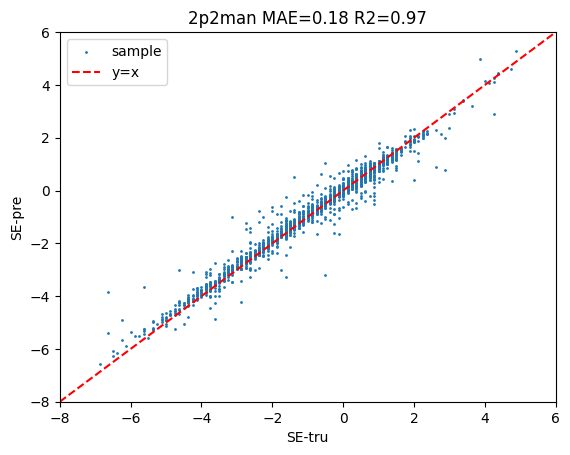

In [10]:
plt.scatter(tru,pre,s=1,label='sample')
plt.xlim(-8,6)
plt.ylim(-8,6)
x_line = np.linspace(-8, 6, 300)
y_line = x_line
# 绘制 y=x 线
plt.plot(x_line, y_line, 'r--',label='y=x')
plt.xlabel('SE-tru')
plt.ylabel('SE-pre')
plt.title('2p2man MAE=0.18 R2=0.97')
plt.legend()
plt.show()

In [21]:
tru

array([ 0.25 ,  0.   , -2.   ,  1.   ,  0.125,  1.125,  0.625, -0.375,
        0.375, -0.375,  0.5  ,  0.875, -0.375, -3.625, -2.875,  0.5  ,
        0.125,  2.125, -4.125, -2.25 , -1.125,  0.25 ,  0.25 , -1.625,
        1.5  , -0.125, -2.75 , -0.625,  6.625, -1.625, -5.875, -2.625,
       -2.5  , -0.875, -3.5  , -2.   , -2.125, -2.875,  0.75 ,  0.875,
       -0.625,  0.125, -0.25 , -0.5  , -1.875,  1.125, -4.5  ,  0.875,
       -1.75 ,  0.375, -1.5  , -2.625, -3.75 , -0.125,  0.625, -1.5  ,
       -0.25 , -0.625, -6.625, -2.125,  1.125, -2.875, -0.25 ,  0.   ,
       -1.125,  1.5  ,  0.625,  0.375,  0.   ,  0.   ,  0.   ,  0.125,
        0.375,  1.375, -3.625, -2.5  , -5.   , -1.   ,  0.125,  0.875,
       -0.375, -2.   , -1.75 , -1.25 , -2.25 , -1.875, -1.875, -0.625,
       -0.375,  0.375, -4.   , -2.875, -3.75 , -2.125,  0.625,  1.   ,
       -1.125, -0.5  ,  0.25 , -0.125,  0.75 , -3.25 ,  1.   , -3.   ,
       -1.5  , -1.25 ,  1.25 , -0.375,  0.875,  0.375, -3.375,  0.5  ,
      

In [11]:
pre = torch.tensor(pre)
tru = torch.tensor(tru)

In [12]:
r2_score(pre, tru)

tensor(0.9705)

In [17]:
tru1 = tru[:,0]
pre1 = pre[:,0]
data1 = abs(pre1-tru1)
print(np.max(data1),np.min(data1),np.mean(data1))

2.903863 0.0009343624 0.3683292


In [18]:
def searchfori(num):
    sum11 = 0
    sum12 = 0
    sum21 = 0
    sum22 = 0
    for i in range(1549):
        if tru[i] >= num and pre[i] >= num:
            sum11 += 1
        if tru[i] < num and pre[i] < num:
            sum22 += 1
        if tru[i] >= num and pre[i] < num:
            sum12 += 1
        if tru[i] < num and pre[i] >= num:
            sum21 += 1
    return (sum11+sum22)/1549,sum11/(sum11+sum12),sum22/(sum22+sum21)

In [11]:
searchfori(-6)

(0.9961265332472563, 0.9973975276512687, 0.8333333333333334)

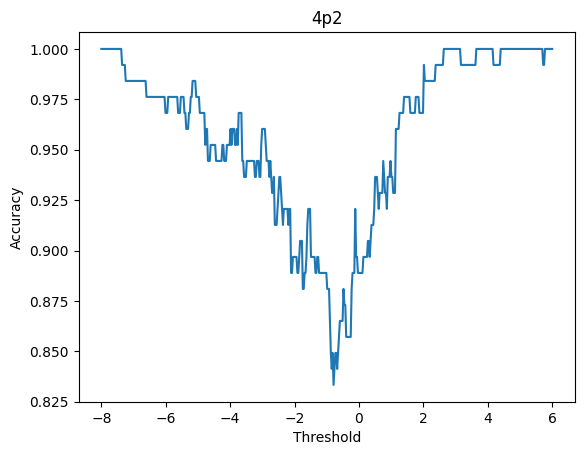

In [12]:
x=np.linspace(-8, 6, 500)
y=[searchfori(i) for i in x]
plt.plot(x,y)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('4p2')
plt.show()

In [13]:
searchfori(-1) 

0.8888888888888888

In [14]:
searchfori(-6)

0.9682539682539683

In [57]:
image = []
imgexam1 = 'autodl-tmp/all/20101021_1_20120303_093501218.jpg'
imgexam2 = 'autodl-tmp/all/20101021_2_20130402_093034890.jpg'
imgexam3 = 'autodl-tmp/all/20101021_3_20140310_160630671.jpg'
imgexam4 = 'autodl-tmp/all/20101021_4_20150511_154011296.jpg'
#imgexam5 = 'autodl-tmp/all/20203451_5_20160412_145300734.jpg'
img1 = Image.open(imgexam1)
img2 = Image.open(imgexam2)
img3 = Image.open(imgexam3)
img4 = Image.open(imgexam4)
#img5 = Image.open(imgexam5)
image.append(val_transform(img1))
image.append(val_transform(img2))
image.append(val_transform(img3))
image.append(val_transform(img4))
#image.append(val_transform(img5))
image = torch.stack(image,dim=0)
image = image.unsqueeze(0)

In [58]:
num = torch.Tensor([0.375,0.875,0.5,-0.875])
num = num.unsqueeze(0)
num = num.unsqueeze(-1)

In [59]:
label = [-1.875,-3.25]

In [60]:
image.size()

torch.Size([1, 4, 3, 512, 512])

In [61]:
num.size()

torch.Size([1, 4, 1])

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load("Xu42b.pth")
image = image.to(device)
num = num.to(device)
output = model(image,num)

In [63]:
output

tensor([[-1.6721]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [65]:
output

tensor([[-3.1201]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
output

tensor([[-3.2477]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [28]:
output

tensor([[-2.3399]], device='cuda:0', grad_fn=<AddmmBackward0>)

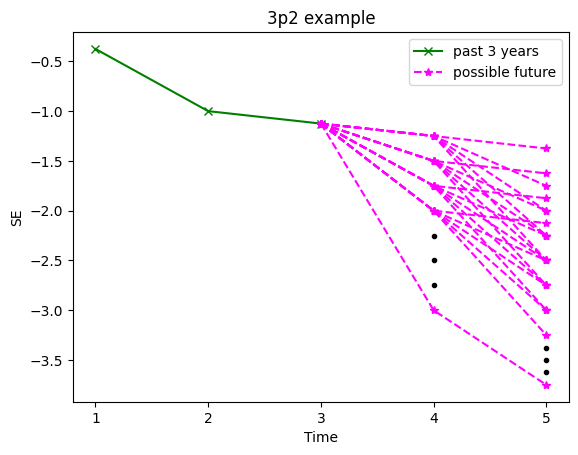

In [22]:
x = [1,2,3]
y = [-0.375,-1,-1.125]
x0 = [3,4,5]

y1 = [-1.125,-1.25,-1.375]
y10 = [-1.125,-1.25,-1.75]
y11 = [-1.125,-1.25,-2]
y12 = [-1.125,-1.25,-2.25]
y13 = [-1.125,-1.25,-2.5]

y2 = [-1.125,-1.5,-1.625]
y20 = [-1.125,-1.5,-2]
y21 = [-1.125,-1.5,-2.25]
y22 = [-1.125,-1.5,-2.5]
y23 = [-1.125,-1.5,-2.75]

y3 = [-1.125,-1.75,-1.875]
y30 = [-1.125,-1.75,-2.25]
y31 = [-1.125,-1.75,-2.5]
y32 = [-1.125,-1.75,-2.75]
y33 = [-1.125,-1.75,-3]

y4 = [-1.125,-2,-2.125]
y40 = [-1.125,-2,-2.5]
y41 = [-1.125,-2,-2.75]
y42 = [-1.125,-2,-3]
y43 = [-1.125,-2,-3.25]


y5 = [-1.125,-3,-3.75]
plt.plot(x,y,marker = 'x',color = 'g',label = 'past 3 years')
#plt.plot(x0,y1,linestyle = '--',marker = '*',color = 'b',label = 'tru future')
#plt.plot(x0,y2,linestyle = '--',marker = '*',color = 'r',label = 'pre future')
plt.plot(x0,y1,linestyle = '--',marker = '*',color = 'fuchsia',label = 'possible future')
plt.plot(x0,y10,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y11,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y12,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y13,linestyle = '--',marker = '*',color = 'fuchsia')

plt.plot(x0,y2,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y20,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y21,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y22,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y23,linestyle = '--',marker = '*',color = 'fuchsia')

plt.plot(x0,y3,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y30,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y31,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y32,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y33,linestyle = '--',marker = '*',color = 'fuchsia')

plt.plot(x0,y4,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y40,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y41,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y42,linestyle = '--',marker = '*',color = 'fuchsia')
plt.plot(x0,y43,linestyle = '--',marker = '*',color = 'fuchsia')

plt.plot(x0,y5,linestyle = '--',marker = '*',color = 'fuchsia')

xx1=[4,4,4]
yy1=[-2.25,-2.5,-2.75]
xx2=[5,5,5]
yy2=[-3.375,-3.5,-3.625]
plt.scatter(xx1,yy1,marker = '.',color = 'black')
plt.scatter(xx2,yy2,marker = '.',color = 'black')
my_x_ticks = np.arange(1, 6, 1)
#my_y_ticks = np.arange(-6, 0, 1)
plt.xticks(my_x_ticks)
#plt.yticks(my_y_ticks)
plt.xlabel('Time')
plt.ylabel('SE')
plt.title('3p2 example')
plt.legend()
plt.show()

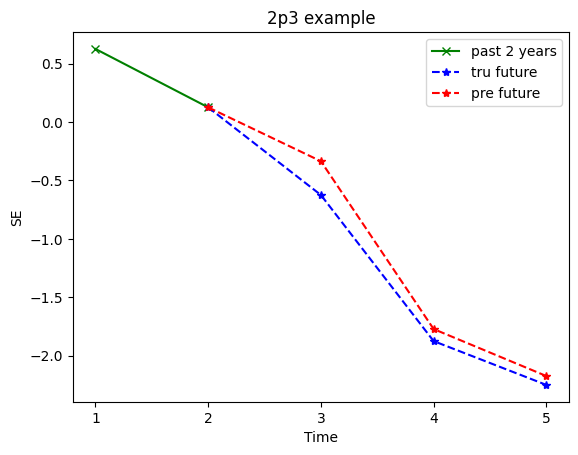

In [50]:
x = [1,2]
y = [0.625,0.125]
x0 = [2,3,4,5]
y1 = [0.125,-0.625,-1.875,-2.25]
y2 = [0.125,-0.336,-1.772,-2.174]
plt.plot(x,y,marker = 'x',color = 'g',label = 'past 2 years')
plt.plot(x0,y1,linestyle = '--',marker = '*',color = 'b',label = 'tru future')
plt.plot(x0,y2,linestyle = '--',marker = '*',color = 'r',label = 'pre future')
my_x_ticks = np.arange(1, 6, 1)
plt.xticks(my_x_ticks)
plt.xlabel('Time')
plt.ylabel('SE')
plt.title('2p3 example')
plt.legend()
plt.show()

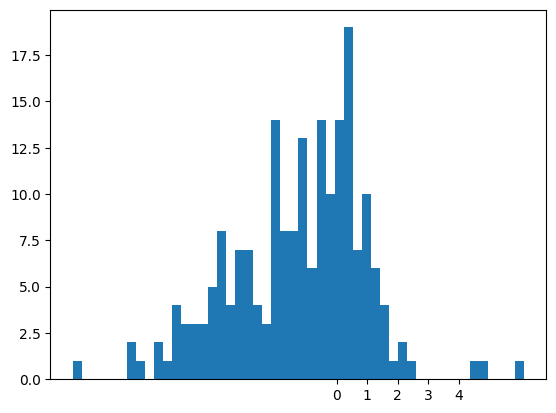

In [14]:
plt.hist(tru,bins=50)
plt.xticks(np.arange(0,5,1))
plt.show()

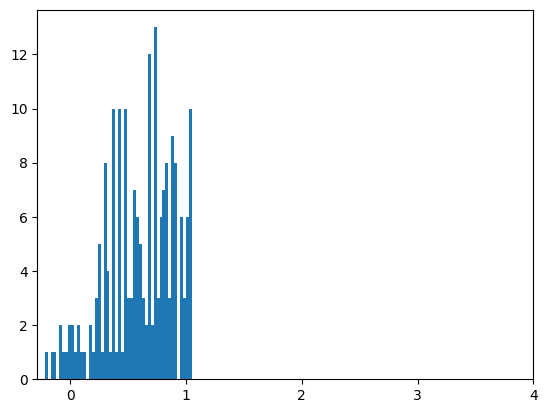

In [15]:
plt.hist(pre,bins=50)
plt.xticks(np.arange(0,5,1))
plt.show()

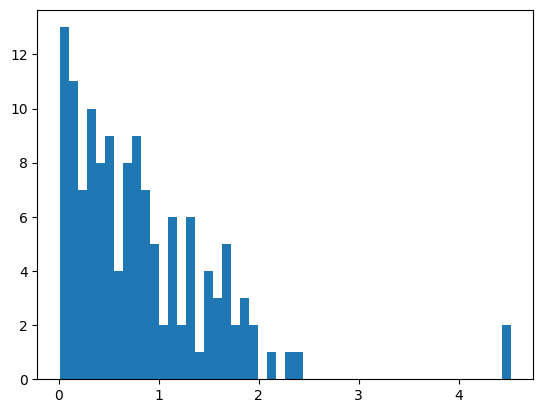

In [17]:
plt.hist(data,bins=50)
plt.xticks(np.arange(0,5,1))
plt.show()

In [6]:
def colorhist(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, i = cv.split(hsv)
    h_eq = cv.equalizeHist(h)
    s_eq = cv.equalizeHist(s)
    i_eq = cv.equalizeHist(i)
    hsi_eq = cv.merge([h_eq, s_eq, i_eq])
    img_eq = cv.cvtColor(hsi_eq, cv.COLOR_HSV2BGR)
    return img_eq

In [27]:
model = torch.load("Fen11b.pth").cuda()

In [23]:
model

ImageSequenceModel(
  (cnn_encoder): ResNet34Encoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): B

In [24]:
model.cnn_encoder.features[-1][-1].bn2

BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [62]:
class cammodel(nn.Module):
    def __init__(self):
        super(cammodel, self).__init__()
        self.model = torch.load("Fen11b.pth")
    def forward(self, image_sequence):
        image_sequence = torch.unsqueeze(image_sequence, dim=0)
        batch_size, _, _, _, _ = image_sequence.size()  # [batch_size, seq_len, 3, 512, 512]
        cnn_features = []
        for t in range(self.model.seq_len):
            x = image_sequence[:, t, :, :, :]  # [batch_size, 3, 512, 512]
            cnn_out = self.model.cnn_encoder(x)  # [batch_size, 512]
            cnn_features.append(cnn_out)
        num = torch.Tensor([100])
        num = num.unsqueeze(0)
        feature_sequence = num.unsqueeze(-1).cuda()
        cnn_features = torch.stack(cnn_features, dim=1)  # [batch_size, seq_len, 512]
        rnn_input = torch.cat([cnn_features, feature_sequence], dim=-1)  # [batch_size, seq_len, 513]
        rnn_out, (h_n, c_n) = self.model.rnn(rnn_input) 
        h_n = self.model.dropout(h_n)
        output = self.model.linear(h_n.squeeze(0))  # [batch_size, hidden_size] -> [batch_size, output_size]
        return output

In [35]:
model.cnn_encoder.features[-1][0]

BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [63]:
def main(image_path,imgpath):
    
    model = cammodel()
    target_layer = [model.model.cnn_encoder.features[-1][-1].relu]
    t1 = 0 #0-1
    t2 = 150 #0-255
    t3 = 230 #0-255
    data_transform = val_transform
    img = Image.open(image_path).convert('RGB')
    img0 = img.resize((224,224))
    img = np.array(img0, dtype=np.uint8)
    img_tensor = data_transform(img)
    input_tensor = torch.unsqueeze(img_tensor, dim=0)
    input_tensor = input_tensor.cuda()
    cam = GradCAM(model=model, target_layers=target_layer)
    target_category = None
    
    imgg = plt.imread(imgpath)
    imgg = cv.resize(imgg,(224,224))
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=target_category)[0] 
    t, grayscale_cam1=cv.threshold(grayscale_cam,t1,255, cv.THRESH_TOZERO)
    
    
    visualization0 = overlay_mask(img0, Image.fromarray(grayscale_cam), alpha=0.75) # alpha越小，原图越淡
    visualization1 = overlay_mask(img0, Image.fromarray(grayscale_cam), alpha=0.75) # alpha越小，原图越淡
    
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb_origin = gb_model(input_tensor, target_category=None)
    gb_show = deprocess_image(gb_origin)
    cam_mask = cv.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    
    guided_gradcam = deprocess_image(cam_mask * gb_origin)
    t, guided_gradcam1 = cv.threshold(guided_gradcam,t2,255, cv.THRESH_TOZERO)
    
    visualization10 = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      guided_gradcam.astype(dtype=np.float32) / 255.,
                                      use_rgb=True)
    visualization11 = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      guided_gradcam1,
                                      use_rgb=True)
    
    
    CH_guided_gradcam = colorhist(guided_gradcam)
    t, CH_guided_gradcam1 = cv.threshold(CH_guided_gradcam,t3,255, cv.THRESH_TOZERO)
    
    visualization20 = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      CH_guided_gradcam.astype(dtype=np.float32) / 255.,
                                      use_rgb=True)
    visualization21 = show_cam_on_image(img.astype(dtype=np.float32) / 255.,
                                      CH_guided_gradcam1,
                                      use_rgb=True)     
    
    #mask = cv.cvtColor(CH_guided_gradcam1, cv.COLOR_RGB2GRAY)
    #mask[mask > 0] = 255

    # 使用bitwise_and函数，将图片2的掩码部分设为0，即黑色
    #imgg = cv.bitwise_and(imgg, imgg, mask = cv.bitwise_not(mask))

    # 使用bitwise_or函数，将图片1和图片2的非0部分合并
    #result = cv.bitwise_or(CH_guided_gradcam1, imgg)
    
    plt.figure(figsize=(20,15))
    plt.subplot(4,5,1)
    plt.imshow(img)
    plt.subplot(4,5,2)
    plt.imshow(grayscale_cam)
    plt.subplot(4,5,3)
    plt.imshow(grayscale_cam1)
    plt.subplot(4,5,4)
    plt.imshow(visualization0)
    plt.subplot(4,5,5)
    plt.imshow(visualization1)
    plt.subplot(4,5,6)
    plt.imshow(img)
    plt.subplot(4,5,7)
    plt.imshow(guided_gradcam)
    plt.subplot(4,5,8)
    plt.imshow(guided_gradcam1)
    plt.subplot(4,5,9)
    plt.imshow(visualization10)
    plt.subplot(4,5,10)
    plt.imshow(imgg+guided_gradcam1*5)
    plt.subplot(4,5,11)
    plt.imshow(img)
    plt.subplot(4,5,12)
    plt.imshow(CH_guided_gradcam)
    plt.subplot(4,5,13)
    plt.imshow(CH_guided_gradcam1)
    plt.subplot(4,5,14)
    plt.imshow(visualization20)
    #plt.imshow(result)
    plt.subplot(4,5,15)
    plt.imshow(imgg+CH_guided_gradcam1*5)
    plt.show()

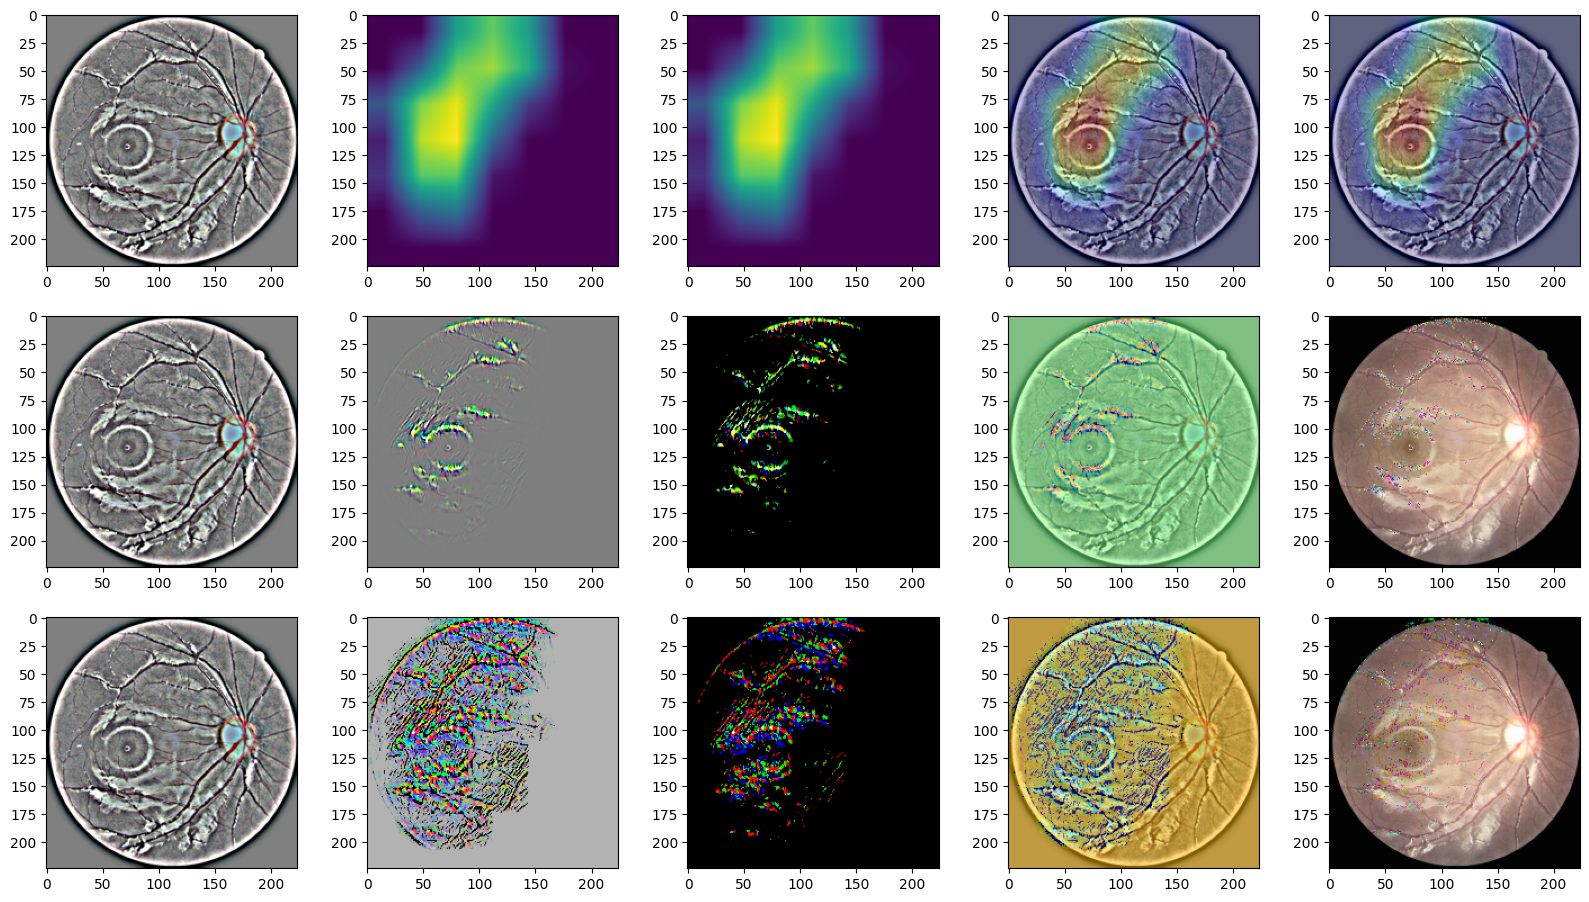

In [92]:
main("autodl-tmp/all/20103121_1_20120222_143535875.jpg","autodl-tmp/20103121_1_20120222_143535875.jpg")

In [2]:
x = [1,1,1,1,1,2,2,2,2,3,3,3,4,4,5]
y = [1,2,3,4,5,1,2,3,4,1,2,3,1,2,1]
z_mae = [0.402,  0.526,  0.772,  0.881,  1.095, 0.353,  0.517,  0.773,  0.912, 0.337,  0.563,  0.833,  0.368,  0.59, 0.433]
z_r2 = [0.91,  0.85,  0.71,  0.689,  0.56, 0.933,  0.874,  0.687,  0.659, 0.94,  0.85,  0.72,  0.921,  0.905, 0.926]
z_acc = [0.9251,0.8715,0.8300,0.8089,0.7828,0.9258,0.8839,0.8314,0.7857,0.9051,0.8675,0.7955,0.8885,0.873,0.8908]
z_auc = [0.975,  0.942,  0.91,  0.885,  0.852, 0.978,  0.952,  0.905,  0.844, 0.973,  0.931,  0.869,  0.962,  0.954, 0.968]

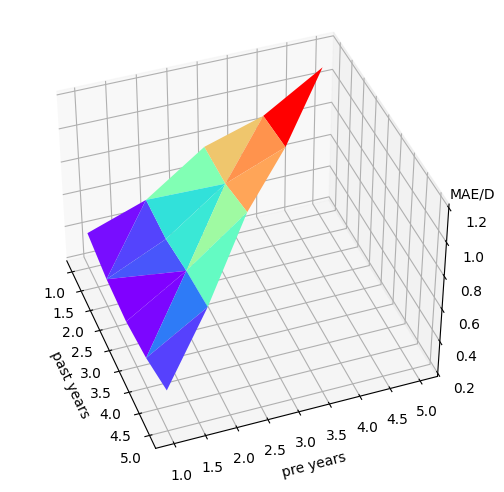

In [3]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.set_zlim(0.2,1.2)
#作图
ax.plot_trisurf(x,y,z_mae,cmap='rainbow') 
# 改变cmap参数可以控制三维曲面的颜色组合, 一般我们见到的三维曲面就是 rainbow 的
ax.set_xlabel('past years')
ax.set_ylabel('pre years')
ax.text2D(1, 0.6, 'MAE/D', transform=ax.transAxes, ha='center', va='center')
ax.view_init(40,-20)
plt.show()

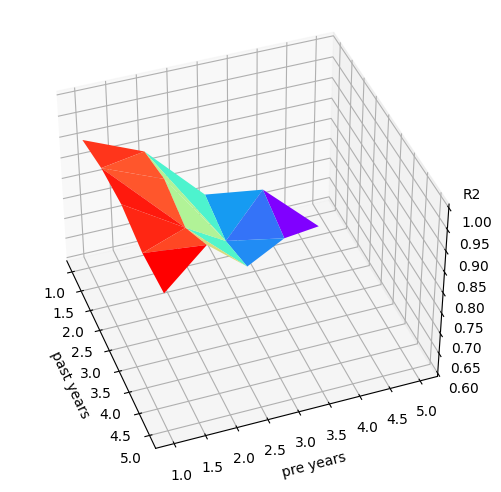

In [51]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.set_zlim(0.6,1)
#作图
ax.plot_trisurf(x,y,z_r2,cmap='rainbow') 
# 改变cmap参数可以控制三维曲面的颜色组合, 一般我们见到的三维曲面就是 rainbow 的
ax.set_xlabel('past years')
ax.set_ylabel('pre years')
ax.text2D(1, 0.6, 'R2', transform=ax.transAxes, ha='center', va='center')
ax.view_init(40,-20)
plt.show()

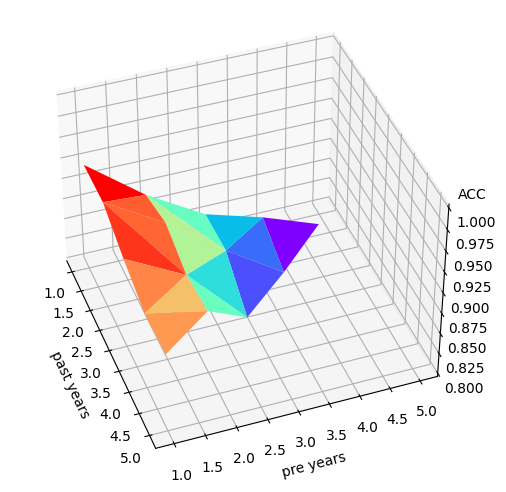

In [4]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.set_zlim(0.8,1)
#作图
ax.plot_trisurf(x,y,z_acc,cmap='rainbow') 
# 改变cmap参数可以控制三维曲面的颜色组合, 一般我们见到的三维曲面就是 rainbow 的
ax.set_xlabel('past years')
ax.set_ylabel('pre years')
ax.text2D(1, 0.6, 'ACC', transform=ax.transAxes, ha='center', va='center')
ax.view_init(40,-20)
plt.show()

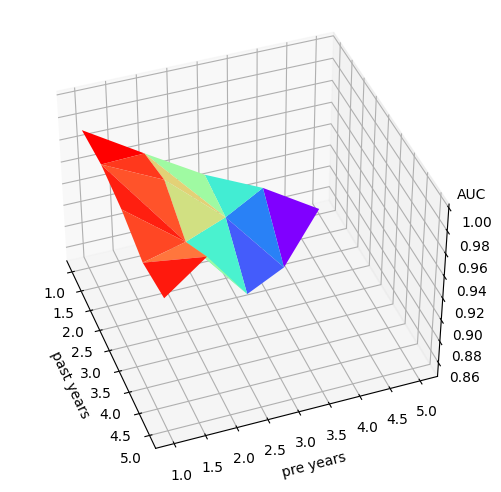

In [5]:
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.set_zlim(0.85,1)
#作图
ax.plot_trisurf(x,y,z_auc,cmap='rainbow') 
# 改变cmap参数可以控制三维曲面的颜色组合, 一般我们见到的三维曲面就是 rainbow 的
ax.set_xlabel('past years')
ax.set_ylabel('pre years')
ax.text2D(1, 0.6, 'AUC', transform=ax.transAxes, ha='center', va='center')
ax.view_init(40,-20)
plt.show()